In [ ]:
# Import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Set display options
np.set_printoptions(precision=3)
pd.options.display.precision = 3
%matplotlib inline

In [ ]:
# Import dataset and checking data available

# Step 1: Upload the file
uploaded = files.upload()

# Step 2: Load the file into a pandas DataFrame
file_name = list(uploaded.keys())[0]  # Get the uploaded file name
print(f"Uploaded file: {file_name}")

# Load the file into a DataFrame
mpg = pd.read_excel(file_name)

# Step 3: Display the first few rows of the DataFrame
print("\nData Preview:")
print(mpg.head())

Saving mpg.data.xlsx to mpg.data.xlsx
Uploaded file: mpg.data.xlsx

Data Preview:
    mpg  cylinders  displayments  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model year  origin                   car name  Unnamed: 9  Unnamed: 10  \
0          70       1  chevrolet chevelle malibu         NaN          NaN   
1          70       1          buick skylark 320         NaN          NaN   
2          70       1         plymouth satellite         NaN          NaN   
3          70       1              amc rebel sst         NaN          NaN   
4          70       1                ford torino         NaN          NaN   

   Unnamed: 11 Unnamed: 12  
0    

In [ ]:
# Preprocessing steps from D02

In [ ]:
# Drop unnecessary columns

mpg = mpg.drop(columns = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'])

In [ ]:
# Correctly rename column "displayments"

mpg = mpg.rename(columns={'displayments': 'displacement'})

In [ ]:
# Replace the two-digit year into a four-digit year, replace the model year column and drop the new column

mpg['model_year_full'] = mpg['model year'].apply(lambda x: 1900 + x if x >= 70 else 2000 + x)
mpg['model year'] = mpg['model_year_full']
mpg.drop('model_year_full', axis=1, inplace=True)

In [ ]:
# Drop null values for the column 'mpg' and replace nulls in the 'horsepower' column with median

mpg = mpg.dropna(subset=["mpg"])
mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].median())

pd.isnull(mpg).sum()

<ipython-input-7-b6cd9bb2866f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].median())


,0
mpg,0
cylinders,0
displacement,0
horsepower,0
weight,0
acceleration,0
model year,0
origin,0
car name,0


In [ ]:
# Change data type for displacement and horsepower

columns_for_change = ['displacement', 'horsepower']
mpg[columns_for_change] = mpg[columns_for_change].astype(int)

In [ ]:
# Split the "car model" column to make two separate columns "brand" and "car name"

mpg[['brand', 'model']] = mpg['car name'].str.split(' ', n=1, expand=True)
mpg['model'] = mpg['model'].str.replace(' ', ' ', regex=False)

In [ ]:
# Remove "car name" and "model" columns

mpg.drop('car name', axis=1, inplace=True)
mpg.drop('model', axis=1, inplace=True)

In [ ]:
# Correct the mispelled brand names

brand_corrections = {
    "vw": "volkswagen",
    "maxda": "mazda",
    "chevroelt": "chevrolet",
    "chevy": "chevrolet",
    "toyouta": "toyota",
    "mercedes": "mercedes-benz","vokswagen": "volkswagen","capri":"ford","mercury":"ford","triumph":"bmw","plymouth":"chrysler"}
mpg["brand"] = mpg["brand"].replace(brand_corrections)

In [ ]:
# Determine the top brands (top 5 by count). One-hot encode the top brands and combine others

top_brands = mpg["brand"].value_counts().nlargest(5).index
mpg_encoded = pd.get_dummies(mpg["brand"].where(mpg["brand"].isin(top_brands), "other"))

In [ ]:
# Merge "mpg" and "mpg_endoded" DataFrames and drop "brand" column

mpg = pd.concat([mpg, mpg_encoded], axis=1)
mpg.drop('brand', axis=1, inplace=True)

In [ ]:
# New column Efficiency replacing numbers with categories
# (max - min) / 3 -> low (3), medium (2), high (1) fuel efficiency

# Calculate min, max, and range
min_mpg = mpg['mpg'].min()
max_mpg = mpg['mpg'].max()
range_mpg = max_mpg - min_mpg

# Calculate thresholds
thresholds = [min_mpg + range_mpg * i / 3 for i in (1, 2)]

# Define bins and labels
bins = [float('-inf')] + thresholds + [float('inf')]
labels = [3, 2, 1]  # Low (3), Medium (2), High (1)

# Apply classification
mpg['efficiency'] = pd.cut(mpg['mpg'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
# Remove "mpg" column

mpg.drop('mpg', axis=1, inplace=True)

mpg.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,amc,chevrolet,chrysler,dodge,ford,other,efficiency
0,8,307,130,3504,12.0,1970,1,False,True,False,False,False,False,3
1,8,350,165,3693,11.5,1970,1,False,False,False,False,False,True,3
2,8,318,150,3436,11.0,1970,1,False,False,True,False,False,False,3
3,8,304,150,3433,12.0,1970,1,True,False,False,False,False,False,3
4,8,302,140,3449,10.5,1970,1,False,False,False,False,True,False,3


In [ ]:
# D03 Model - Evaluate - Predict - Fine Tune
# KNN - Balanced

In [ ]:
# KNN Preparation

knn_df = mpg.copy()

In [ ]:
# Split the data into features (X) and target (y)
# features: cylinders, displacement, horsepower, weight, acceleration, model year, origin, brands, performance
# target: efficiency

X_knn = knn_df.drop(columns=['efficiency'])
y_knn = knn_df['efficiency']

In [ ]:
X_knn.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,amc,chevrolet,chrysler,dodge,ford,other
0,8,307,130,3504,12.0,1970,1,False,True,False,False,False,False
1,8,350,165,3693,11.5,1970,1,False,False,False,False,False,True
2,8,318,150,3436,11.0,1970,1,False,False,True,False,False,False
3,8,304,150,3433,12.0,1970,1,True,False,False,False,False,False
4,8,302,140,3449,10.5,1970,1,False,False,False,False,True,False


In [ ]:
y_knn.head()

,efficiency
0,3
1,3
2,3
3,3
4,3


In [ ]:
# Feature scaling

scaler = StandardScaler()
X_knn_scaled = scaler.fit_transform(X_knn)

In [ ]:
# Split Data in train and test sets

X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn_scaled, y_knn, test_size=0.2, random_state=42)

print(f'Training Set Size: {X_knn_train.shape[0]} samples')
print(f'Test Set Size: {X_knn_test.shape[0]} samples')

Training Set Size: 318 samples
Test Set Size: 80 samples


In [ ]:
# Train the KNN model - Define the Classifier

knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [ ]:
# Fit the model on training data

knn_model.fit(X_knn_train, y_knn_train)

KNeighborsClassifier(weights='distance')

In [ ]:
# Predict on training data and test data

pred_train = knn_model.predict(X_knn_train)
pred_test = knn_model.predict(X_knn_test)

In [ ]:
# Evalute Accuracy - Get the score on the training & test set
train_score = knn_model.score(X_knn_train, y_knn_train)
test_score = knn_model.score(X_knn_test, y_knn_test)

print(f"Training Accuracy: {train_score:.3f}")
print(f"Test Accuracy: {test_score:.3f}")

Training Accuracy: 1.000
Test Accuracy: 0.863


In [ ]:
# Optimize KNN with Different Values of k - fit/score with different number of neighbors

print("\nOptimizing KNN by testing different values of k:")

k_values = range(1, 20)
knn_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k) # 11
    knn.fit(X_knn_train, y_knn_train)
    print(f'{k} --> {knn.score(X_knn_test, y_knn_test)}')


Optimizing KNN by testing different values of k:
1 --> 0.825
2 --> 0.8125
3 --> 0.8375
4 --> 0.8625
5 --> 0.85
6 --> 0.85
7 --> 0.825
8 --> 0.825
9 --> 0.8
10 --> 0.8
11 --> 0.7875
12 --> 0.8
13 --> 0.8
14 --> 0.7875
15 --> 0.7875
16 --> 0.7875
17 --> 0.8
18 --> 0.8125
19 --> 0.8


In [ ]:
# Fit/Predict with different number of neighbors

knn_accuracies=[]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_knn_train, y_knn_train)
    knn_accuracies.append(accuracy_score(y_knn_test, knn.predict(X_knn_test)))

Best accuracy 86.25% for k=4


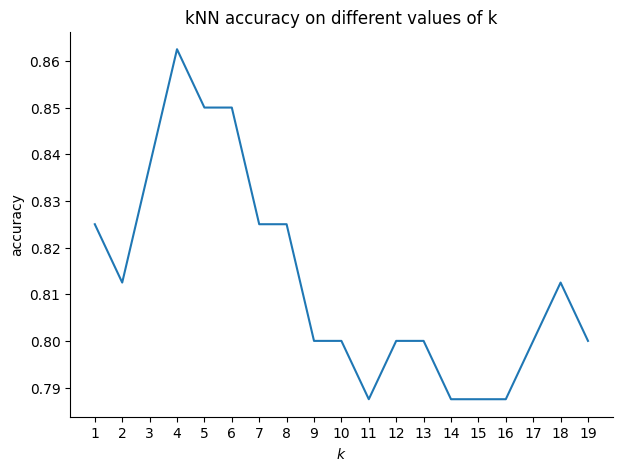

In [ ]:
# Plot accuracies

fig = plt.figure(figsize=(7, 5))

ax = plt.subplot(111)
ax.plot(range(1, 20, 1), knn_accuracies)

# aesthetic parameters
ax.set_xticks(range(1, 20))
ax.set_xlabel('$k$')
ax.set_ylabel('accuracy')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_title('kNN accuracy on different values of k')

print(f'Best accuracy {max(knn_accuracies) * 100:.2f}% for k={list(range(1, 20))[np.argmax(knn_accuracies)]}')

In [ ]:
# Calculate te Best Accuracy

best_k = k_values[np.argmax(knn_accuracies)]
best_accuracy = max(knn_accuracies)
print(f"Best Accuracy: {best_accuracy * 100:.2f}% achieved at k={best_k}")

Best Accuracy: 86.25% achieved at k=4


In [ ]:
# Evaluate the Best Model

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_knn_train, y_knn_train)
y_pred = knn.predict(X_knn_test)

Classification Report:
              precision    recall  f1-score   support

           1       0.89      1.00      0.94         8
           2       0.91      0.79      0.85        39
           3       0.81      0.91      0.86        33

    accuracy                           0.86        80
   macro avg       0.87      0.90      0.88        80
weighted avg       0.87      0.86      0.86        80


Confusion Matrix:


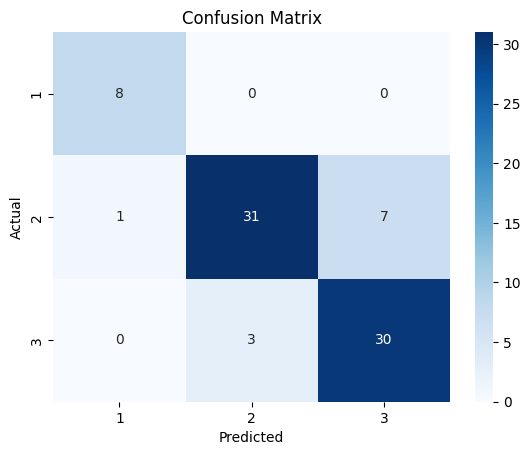

In [ ]:
# Classification Report

print("Classification Report:")
print(classification_report(y_knn_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_knn_test, y_pred)

# Get unique class labels from y_knn
class_labels = np.unique(y_knn)

# Confusion Matrix

# Use class_labels for xticklabels and yticklabels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#Class 1: Precision: 0.89, Recall: 1.00, F1-Score: 0.94 (Outstanding performance in predicting class 1).
Class 2:Precision: 0.91, Recall: 0.79, F1-Score: 0.85 (Solid performance, with potential for improvement in recall).
Class 3: Precision: 0.81, Recall: 0.91, F1-Score: 0.86 (Strong performance with a good balance of precision and recall).
Overall, the model achieves an accuracy of 86% and a macro average F1-score of 0.88. It performs particularly well in predicting class 1, while there is slight room for improvement in class 2.
The model demonstrates a balanced performance across all classes.